# Community Detection in Graphs
### Mini Project for Massive Graph Management and Analytics

This notebook performs a comparative analysis of community detection algorithms on two different graph datasets.

### Setup

First, let's import all the necessary libraries.

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import requests
import gzip
import shutil
import igraph as ig
import community.community_louvain as community_louvain
from sklearn.metrics import adjusted_rand_score
from collections import Counter, defaultdict

## Part 1: Facebook Graph

### 1.1 Data Loading and Description
This graph is an **undirected** social network from Facebook. It is composed of 'friends lists' (or 'circles') from Facebook collected from survey participants using the Facebook app. The dataset includes node features, circles and ego networks. An 'ego network' is composed of a central user and all their friends. There are 4,039 nodes representing anonymized Facebook users, and 88,234 edges representing friendship connections between two users. 

The data was extracted from SNAP at https://snap.stanford.edu/data/ego-Facebook.html

In [2]:
# Load the Facebook graph from the edgelist file
txt_file = 'data/facebook_combined.txt'
G_fb = nx.read_edgelist(txt_file, create_using=nx.Graph(), nodetype=int)

#### Visualizing the Data

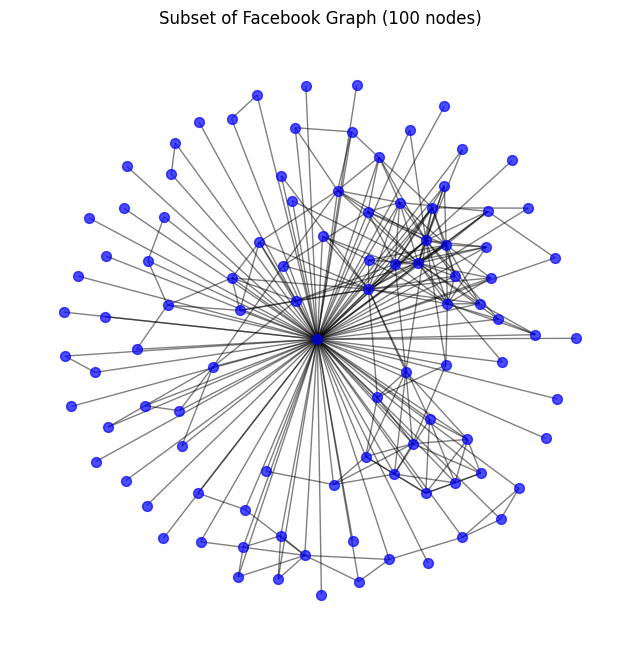

In [3]:
# Sample 100 nodes for visualization
subset_nodes = list(G_fb.nodes())[:100] 

# Create the subgraph from the subset of nodes
G_sub = G_fb.subgraph(subset_nodes)

# Draw the subgraph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_sub, seed=42) 
nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.title('Subset of Facebook Graph (100 nodes)')
plt.axis('off')
plt.show()

This visualization shows a subset of 100 nodes from the Facebook social graph, where each blue dot represents a user and each line shows a friendship link. The graph highlights how some users act have many direct connections, while others have less, illustrating the structure of social networks where there can be influential users connecting to many other users, and otherwise.

### 1.2 Preliminary Analysis

Now, let's analyze the graph's basic properties and identify the most important nodes.

In [4]:
n_nodes = G_fb.number_of_nodes()
n_edges = G_fb.number_of_edges()
avg_degree = (2 * n_edges) / n_nodes
density = nx.density(G_fb)

print(f"Dataset: Facebook Social Network")
print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")
print(f"Average Degree: {avg_degree:.4f}")
print(f"Graph Density: {density:.6f}")

# Check if the graph is connected
if nx.is_connected(G_fb):
    print("Graph is connected.")
else:
    print(f"Graph is not connected. Components: {nx.number_connected_components(G_fb)}")

Dataset: Facebook Social Network
Nodes: 4039
Edges: 88234
Average Degree: 43.6910
Graph Density: 0.010820
Graph is connected.


**Key Insights**

- With 4,039 users (represented by nodes), this is quite a small sample of Facebook's social network. There are also 88,234 edges which represents the same number of friendship links between users. 
- The average degree is computed to be 43.69, which means that on average, each user has around 44 friends. 
- The graph density is 0.011 which means the graph is quite sparse, which is expected since users form clusters of friends rather than connecting to every user in the network. 
- The graph being connected is also expected for a social network, where every user is reachable to each other through friends of friends. 

#### Centrality Measurements



In [5]:
# Degree Centrality 
# This measures the number of friends a user has
deg_cent = nx.degree_centrality(G_fb)
top_5_degree = sorted(deg_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Degree Centrality (Most 'Popular'):")
for node, centrality in top_5_degree:
    print(f"  Node {node}: {centrality:.4f} (Actual friends: {G_fb.degree[node]})")

# Betweenness Centrality 
# Measures how often a node lies on shortest paths between others (bridges)
bet_cent = nx.betweenness_centrality(G_fb, k=1000, seed=42)
top_5_betweenness = sorted(bet_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Betweenness Centrality (Best 'Bridges'):")
for node, centrality in top_5_betweenness:
    print(f"  Node {node}: {centrality:.4f}")

# Closeness Centrality
# Measures how close a network node is to all other nodes (fastest access)
closeness_cent = nx.closeness_centrality(G_fb)
top_5_closeness = sorted(closeness_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Closeness Centrality (Fastest access):")
for node, centrality in top_5_closeness:
    print(f"  Node {node}: {centrality:.4f}")



Top 5 Nodes by Degree Centrality (Most 'Popular'):
  Node 107: 0.2588 (Actual friends: 1045)
  Node 1684: 0.1961 (Actual friends: 792)
  Node 1912: 0.1870 (Actual friends: 755)
  Node 3437: 0.1355 (Actual friends: 547)
  Node 0: 0.0859 (Actual friends: 347)

Top 5 Nodes by Betweenness Centrality (Best 'Bridges'):
  Node 107: 0.4852
  Node 1684: 0.3449
  Node 3437: 0.2268
  Node 1912: 0.2232
  Node 0: 0.1520

Top 5 Nodes by Closeness Centrality (Fastest access):
  Node 107: 0.4597
  Node 58: 0.3974
  Node 428: 0.3948
  Node 563: 0.3939
  Node 1684: 0.3936


**Key Insights**
- Degree centrality counts the number of direct connections (friends) each node has. Nodes with high degree centrality are the most "popular" users since they have the most friends within the network. In this case, node 107 is the most "popular" user with 1045 friends.
- Betweenness centrality measures how often a node sits on the shortest paths between other pairs of nodes, thus acting as a bridge between nodes. Node 107 is also the best "bridge" in this case, which is expected since it connects to the most number of nodes.
- Closeness centrality measures how easily a node can reach all other nodes (by the path length to all other nodes). Interestingly, node 107 got the best centrality score yet again, which makes it the most important node based on these measures.
- Some nodes (e.g., node 58, node 428, node 563) appear in closeness but not in degree or betweenness, suggesting they have quick access to the nodes even if they aren't the most connected or the best bridges.


In [6]:
# Eigenvector Centrality
# Measures influence of a node in the network by the quality of its connections
eigen_cent = nx.eigenvector_centrality(G_fb, max_iter=1000, tol=1e-06)
top_5_eigen = sorted(eigen_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Eigenvector Centrality (Influential nodes):")
for node, centrality in top_5_eigen:
    print(f"  Node {node}: {centrality:.4f}")

# Clustering Coefficient per node
# Measures the how nodes in a graph tend to cluster together
clustering_coeff = nx.clustering(G_fb)
top_5_clustering = sorted(clustering_coeff.items(), key=lambda item: item[1], reverse=True)[:10]

print("\nTop 10 Nodes by Clustering Coefficient (Local cohesiveness):")
for node, coeff in top_5_clustering:
    print(f"  Node {node}: {coeff:.4f}")


Top 5 Nodes by Eigenvector Centrality (Influential nodes):
  Node 1912: 0.0954
  Node 2266: 0.0870
  Node 2206: 0.0861
  Node 2233: 0.0852
  Node 2464: 0.0843

Top 10 Nodes by Clustering Coefficient (Local cohesiveness):
  Node 32: 1.0000
  Node 33: 1.0000
  Node 35: 1.0000
  Node 42: 1.0000
  Node 44: 1.0000
  Node 46: 1.0000
  Node 47: 1.0000
  Node 52: 1.0000
  Node 63: 1.0000
  Node 70: 1.0000


**Key Insights**
- Eigenvector centrality identifies nodes that are not only well-connected, but are connected to other well-connected nodes. A high eigenvector score means a node has connections to other nodes that themselves are influential. Node 1912 has the highest eigenvector centrality, which means it isn't just popular by degree, but its connections are also well-connected.
- Interestingly, node 107 which topped the previous 3 centrality measures doesn't show up here, which suggests that its connections aren't that influential.
- The clustering coefficient measures the extent to which a node's neighbors are also connected to one another, showing the cohesion of a node's neighborhood. As shown above, the top 10 nodes all got a coefficient of 1.00 which shows that a lot of communities are very tightly knit where every user knows every other user within the network. This is a bit expected from social networks, since there may be groups like families or school groups where we expect everyone knowing everyone else.

In [7]:
# PageRank Centrality
# Measures influence using a random walk model
pagerank_cent = nx.pagerank(G_fb, alpha=0.85)
top_5_pagerank = sorted(pagerank_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by PageRank:")
for node, centrality in top_5_pagerank:
    print(f"  Node {node}: {centrality:.4f}")

# Katz Centrality
# Measures influence considering both direct and indirect connections
katz_cent = nx.katz_centrality_numpy(G_fb, alpha=0.1, beta=1.0)
top_5_katz = sorted(katz_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Katz Centrality:")
for node, centrality in top_5_katz:
    print(f"  Node {node}: {centrality:.4f}")


Top 5 Nodes by PageRank:
  Node 3437: 0.0076
  Node 107: 0.0069
  Node 1684: 0.0064
  Node 0: 0.0063
  Node 1912: 0.0039

Top 5 Nodes by Katz Centrality:
  Node 2696: 0.1064
  Node 2921: 0.0998
  Node 2934: 0.0947
  Node 3275: 0.0850
  Node 2870: 0.0837


**Key Insights**
- PageRank estimates the importance of a node by considering the quantity and quality of its inbound links. This reflects nodes that are frequently visited in a random walk across the network, which signifies how influential it is.
- Interestingly, the PageRank overlaps with the Degree centrality results, albeit with a different order. This is a bit expected due to the nature of PageRank which measures centrality based on inbound links. However, the order changed because there is a measure of link quality as well, which suggests that some links aren't as good as others, even if there are more links in a node.
- Katz centrality counts all walks that lead to a node. This measure obtains nodes that have extended influence in the network, potentially acting as connectors over other paths. We added this to test it out, and it is quite interesting how the nodes here are completely different from the other centrality scores. This could be attributed to the fact that it considers indirect paths as well, and not just the nodes that are directly connected to a user.

#### Visualizations

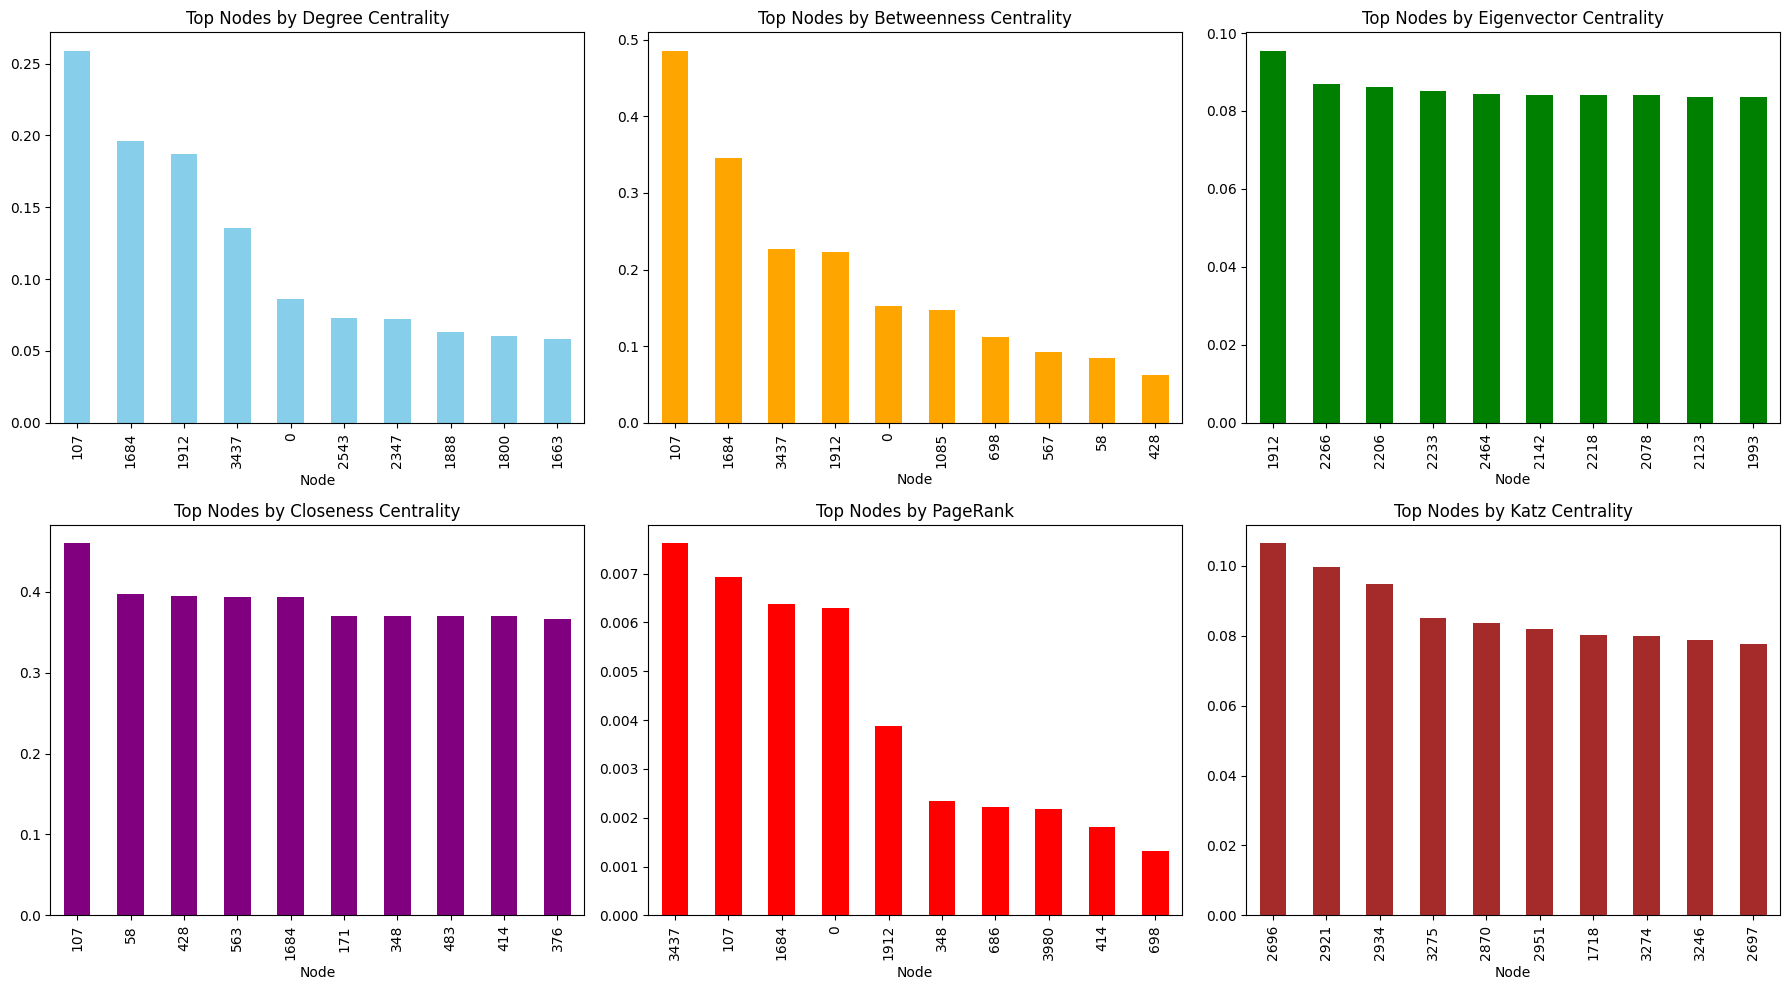

In [8]:
def top_n_df(centrality_dict, n=10):
    top_items = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    return pd.DataFrame(top_items, columns=['Node', 'Centrality'])

centrality_dicts = [
    (deg_cent, 'Degree Centrality', 'skyblue'),
    (bet_cent, 'Betweenness Centrality', 'orange'),
    (eigen_cent, 'Eigenvector Centrality', 'green'),
    (closeness_cent, 'Closeness Centrality', 'purple'),
    (pagerank_cent, 'PageRank', 'red'),
    (katz_cent, 'Katz Centrality', 'brown')
]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (cent_dict, title, color) in zip(axes.flatten(), centrality_dicts):
    top_n_df(cent_dict).plot.bar(x='Node', y='Centrality', legend=False, ax=ax, color=color)
    ax.set_title(f'Top Nodes by {title}')

plt.tight_layout()
plt.show()


**Key Insights**
- This basically just visualized the same values that were obtained previously. This makes it easier to see how much more influential nodes can be for some centrality measurements over others. For instance, Node 107 has a much higher degree and betweenness measurement over other nodes, but when we look at the eigenvector, Katz and closeness centralities, the centrality measurements are much closer to each other. Pagerank shows a sudden drop after the top 4 nodes, highlighting the difference between highly influential nodes and the rest of the network, and how influence is distributed unevenly.

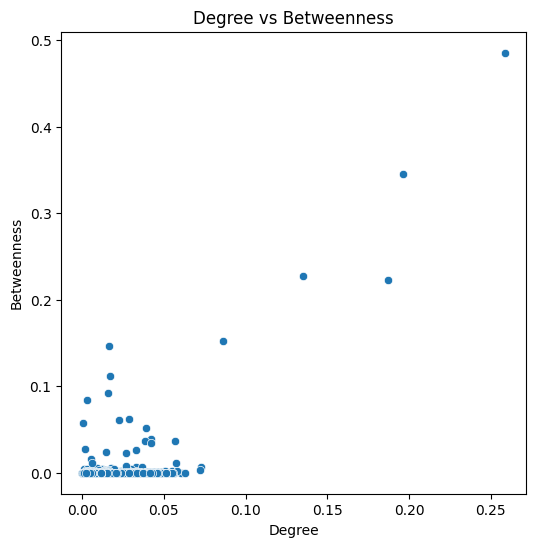

In [17]:
# Scatter plots between degree vs betweenness
df_degree = pd.DataFrame(list(deg_cent.items()), columns=['Node', 'Degree'])
df_betweenness = pd.DataFrame(list(bet_cent.items()), columns=['Node', 'Betweenness'])
df_merged = pd.merge(df_degree, df_betweenness, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged, x='Degree', y='Betweenness')
plt.title('Degree vs Betweenness')
plt.show()

This scatter plot shows the relationship between degree and betweenness centrality. Most nodes have low values on both measures, but a few stand out as having both high degree and high betweenness, indicating they function as key connectors in the network. Generally, nodes with higher degrees also have higher betweenness measurements.

Comparing degree and betweenness centrality is relevant because it helps distinguish between nodes that are simply popular and those that play roles as bridges in the network. 

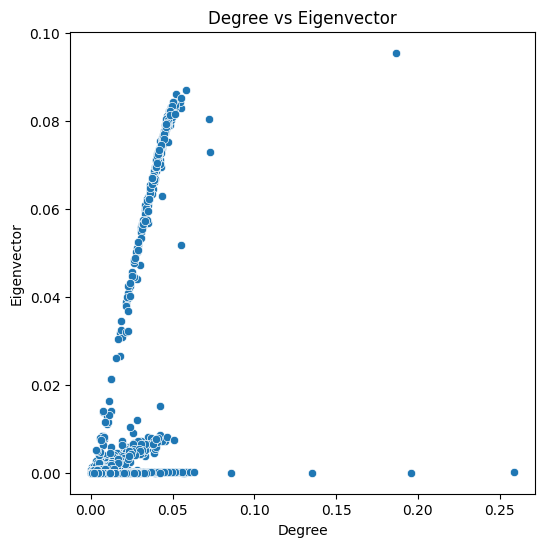

In [19]:
# Scatter plots between degree vs eigenvector
df_degree = pd.DataFrame(list(deg_cent.items()), columns=['Node', 'Degree'])
df_eigen = pd.DataFrame(list(eigen_cent.items()), columns=['Node', 'Eigenvector'])
df_merged = pd.merge(df_degree, df_eigen, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged, x='Degree', y='Eigenvector')
plt.title('Degree vs Eigenvector')
plt.show()

This scatter plot shows the relationship between degree centrality and eigenvector centrality. While the general trend goes upward, where most nodes with higher degree also have higher eigenvector centrality, there are some outliers with high degree but low eigevector scores, suggesting that some "popular" nodes don't really have good quality connections.

It's interesting to compare degree and eigenvector centrality because degree measures just  popularity, while eigenvector centrality captures a node's influence through connections with other influential nodes. This distinction helps reveal whether popular nodes are also truly impactful in the entire network.

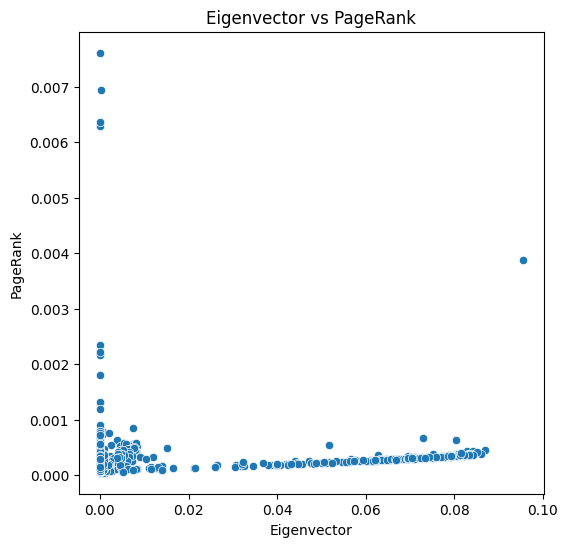

In [18]:
# Scatter plot between eigenvector vs pagerank
df_eigen = pd.DataFrame(list(eigen_cent.items()), columns=['Node', 'Eigenvector'])
df_pagerank = pd.DataFrame(list(pagerank_cent.items()), columns=['Node', 'PageRank'])
df_merged2 = pd.merge(df_eigen, df_pagerank, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged2, x='Eigenvector', y='PageRank')
plt.title('Eigenvector vs PageRank')
plt.show()

This scatter plot compares eigenvector centrality and PageRank for each node. Most nodes have low values for both centralities, but a few outliers stand out with high eigenvector centrality but relatively low Pagerank, and vice versa. This suggests that they rank certain nodes differently depending on the structure of their connections and the type of influence being measured.​

It's interesting to compare them because they emphasize different aspects of the network. Eigenvector centrality assigns importance based on connectivity to other influential nodes, while PageRank takes into account the quality of incoming links, resulting in distinct rankings for certain nodes depending on network structure.

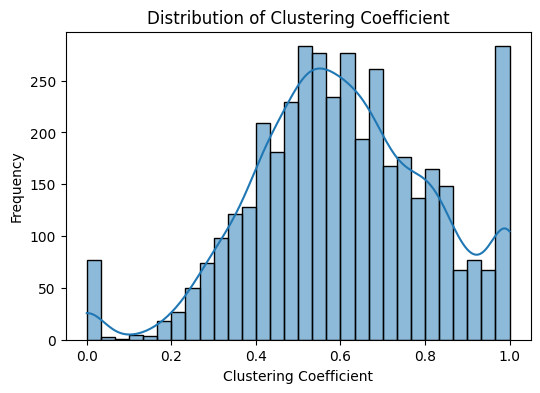

In [10]:
# Histogram of clustering coefficient
plt.figure(figsize=(6,4))
sns.histplot(list(clustering_coeff.values()), bins=30, kde=True)
plt.title('Distribution of Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

his histogram displays the distribution of clustering coefficients in the network. Most nodes have moderate to high local clustering, indicating that users tend to form tightly-connected friend groups; a notable peak at 1.0 shows many perfect cliques, while the left tail reflects users with few mutual connections among their friends. Interestingly, there are some nodes which have 0 clustering coefficient, suggesting that their friends are not friends with each other.

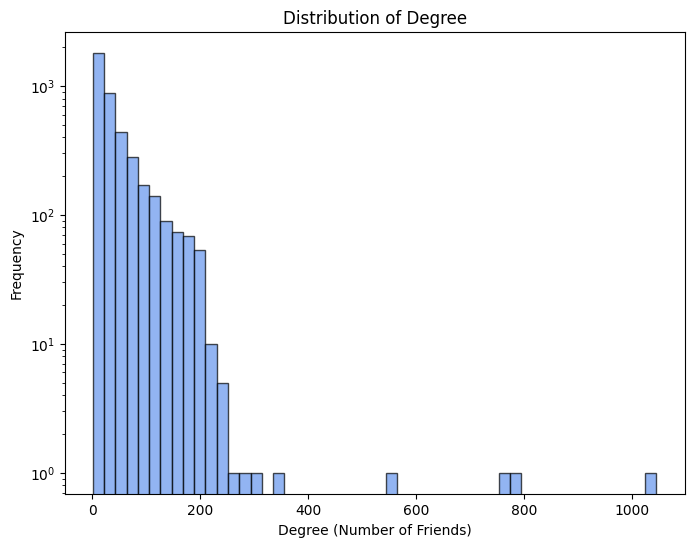

In [23]:
# Get degree sequence
degree_sequence = [degree for node, degree in G_fb.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=50, color='cornflowerblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Degree')
plt.xlabel('Degree (Number of Friends)')
plt.ylabel('Frequency')
plt.yscale('log')  
plt.show()


This histogram shows the degree distribution of the network, showing that most users have a relatively low number of friends, while a few nodes act as very popular nodes with hundreds or even more than a thousand friends. The long tail and rapid drop make sense in social networks, where there should be very few users who are truly popular and have lots of connections.

### 1.3 Community Detection Algorithms

In [51]:
# Community Detection using the Louvain Method
print("Running Louvain algorithm on Facebook graph.")
start_time = time.time()
partition_louvain = community_louvain.best_partition(G_fb)
louvain_time = time.time() - start_time

# Get statistics
num_communities_louvain = len(set(partition_louvain.values()))
community_sizes_louvain = Counter(partition_louvain.values())

print(f"Louvain finished in {louvain_time:.4f} seconds.")
print(f"Louvain found {num_communities_louvain} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_louvain.most_common(5))
    

Running Louvain algorithm on Facebook graph.
Louvain finished in 0.8004 seconds.
Louvain found 15 communities.
Top 5 largest communities (size):
[(5, 554), (9, 548), (1, 432), (8, 432), (4, 423)]


In [52]:
# Community Detection using Label Propagation Algorithm (LPA)
print("\nRunning Label Propagation (LPA) on Facebook graph.")
start_time = time.time()
communities_lpa_sets = nx.community.label_propagation_communities(G_fb)
communities_lpa_list = [c for c in communities_lpa_sets]
lpa_time = time.time() - start_time

# Get statistics
num_communities_lpa = len(communities_lpa_list)
community_sizes_lpa = sorted([len(c) for c in communities_lpa_list], reverse=True)

print(f"LPA finished in {lpa_time:.4f} seconds.")
print(f"LPA found {num_communities_lpa} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_lpa[:5])


Running Label Propagation (LPA) on Facebook graph.
LPA finished in 0.2273 seconds.
LPA found 44 communities.
Top 5 largest communities (size):
[1030, 753, 547, 469, 226]


In [53]:
# Community Detection using Walktrap Algorithm
print("\nRunning Walktrap algorithm on Facebook graph.")
G_fb_ig = ig.Graph.from_networkx(G_fb)
start_time = time.time()
dendrogram = G_fb_ig.community_walktrap()
clusters_walktrap = dendrogram.as_clustering()
walktrap_time = time.time() - start_time

# Get statistics
num_communities_walktrap = len(clusters_walktrap)
community_sizes_walktrap = sorted(clusters_walktrap.sizes(), reverse=True)

print(f"Walktrap finished in {walktrap_time:.4f} seconds.")
print(f"Walktrap found {num_communities_walktrap} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_walktrap[:5])


Running Walktrap algorithm on Facebook graph.
Walktrap finished in 1.3279 seconds.
Walktrap found 77 communities.
Top 5 largest communities (size):
[481, 424, 286, 232, 226]


In [59]:
communities_louvain_list = [set() for _ in range(num_communities_louvain)]
for node, community_id in partition_louvain.items():
    communities_louvain_list[community_id].add(node)

# Computing modularity scores for each algorithm
mod_louvain = nx.community.modularity(G_fb, communities_louvain_list)
mod_lpa = nx.community.modularity(G_fb, communities_lpa_list)
mod_walktrap = G_fb_ig.modularity(clusters_walktrap)

print("\n--- Comparison of Algorithms ---")
print("Algorithm  | Modularity | Num Communities | Time (s)")
print("-----------|------------|-----------------|----------")
print(f"Louvain    | {mod_louvain:.8f} | {num_communities_louvain:<15} | {louvain_time:.4f}")
print(f"LPA        | {mod_lpa:.8f} | {num_communities_lpa:<15} | {lpa_time:.4f}")
print(f"Walktrap   | {mod_walktrap:.8f} | {num_communities_walktrap:<15} | {walktrap_time:.4f}")


--- Comparison of Algorithms ---
Algorithm  | Modularity | Num Communities | Time (s)
-----------|------------|-----------------|----------
Louvain    | 0.83488203 | 15              | 0.8004
LPA        | 0.73684073 | 44              | 0.2273
Walktrap   | 0.81193996 | 77              | 1.3279


**Key Insights**
1. **Modularity:** Louvain achieves the highest modularity, which is expected as its goal is to optimize this specific metric. Walktrap also achieves a very high score, nearly identical to Louvain's. LPA got the lowest Modularity.
2. **Speed:** LPA is by far the fastest, followed by Louvain. Walktrap is the slowest of the three.
3. **Community Structure:** Louvain finds the least amount of communities, followed by LPA and then Walktrap.

**Conclusion:** All three algorithms successfully find a strong community structure (high modularity scores). Louvain achieves the highest modularity (0.83) and finds a moderate number of communities (15), indicating it produces well-separated, high-quality groups, making it excellent for uncovering strong community structure in networks. LPA is the fastest method and finds many more (44) communities, but its modularity is noticeably lower (0.73), suggesting it may oversegment the network into smaller, less cohesive groups. It is a good method if speed is the highest priority. Walktrap yields moderate modularity (0.81) but discovers the largest number of communities (77), taking slightly longer to compute.


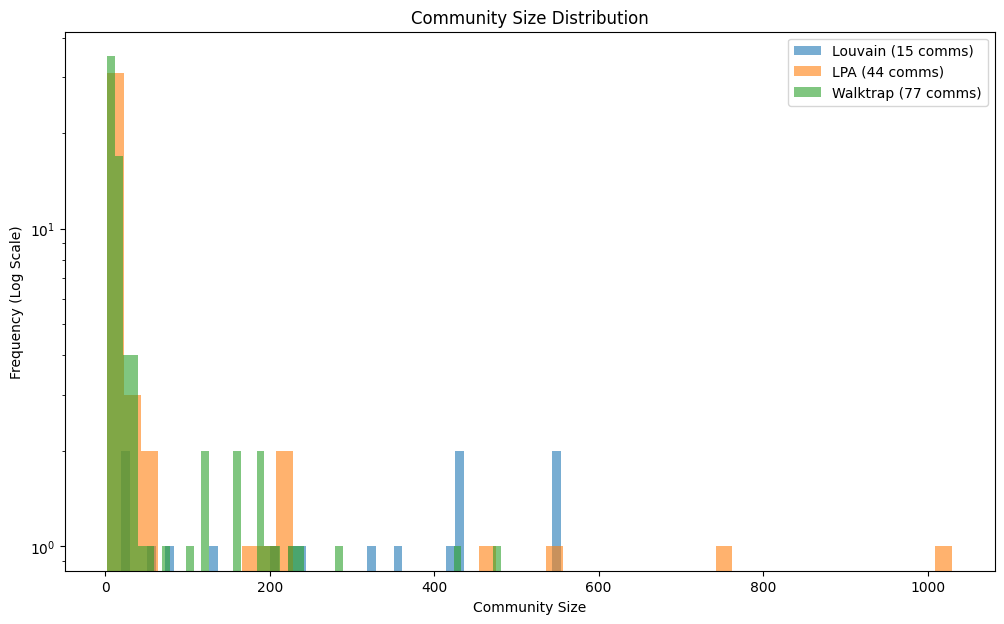

In [60]:
# Generating community size distribution plot
louvain_sizes = [s for s in community_sizes_louvain.values()]
lpa_sizes = community_sizes_lpa
walktrap_sizes = community_sizes_walktrap

plt.figure(figsize=(12, 7))
plt.hist(louvain_sizes, bins=50, log=True, alpha=0.6, label=f'Louvain ({num_communities_louvain} comms)')
plt.hist(lpa_sizes, bins=50, log=True, alpha=0.6, label=f'LPA ({num_communities_lpa} comms)')
plt.hist(walktrap_sizes, bins=50, log=True, alpha=0.6, label=f'Walktrap ({num_communities_walktrap} comms)')
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Frequency (Log Scale)')
plt.legend()

This community size distribution plot compares the output of three algorithms and shows that all tend to identify many small communities and a few larger ones. Louvain consistently finds fewer, larger communities, while Walktrap and LPA detect more but mostly small groups. 

Interestingly, LPA found the largest community with size ~1000, while the bulk of communities returned by Walktrap had sizes <100. Louvain had moderately sized communities with the bulk between 400 and 600.

#### Analyzing the Centrality of Communities

Now, let's analyze the centrality within the communities. For this, we use the Louvain communities for analysis.

In [66]:
# Create dictionaries to hold aggregate scores
comm_avg_degree = defaultdict(float)
comm_avg_betweenness = defaultdict(float)
comm_counts = defaultdict(int)

# Sum up the scores for each community
for node, comm_id in partition_louvain.items():
    comm_avg_degree[comm_id] += deg_cent[node]
    comm_avg_betweenness[comm_id] += bet_cent[node]
    comm_counts[comm_id] += 1

# Calculate the average
for comm_id in comm_avg_degree:
    comm_avg_degree[comm_id] /= comm_counts[comm_id]
    comm_avg_betweenness[comm_id] /= comm_counts[comm_id]

top_5_dense_comms = sorted(comm_avg_degree.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_bridge_comms = sorted(comm_avg_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 Communities (by Average Degree Centrality):")
for comm_id, avg_val in top_5_dense_comms:
    print(f"  Community {comm_id} (Size: {comm_counts[comm_id]}): {avg_val:.4f}")

print("\nTop 5 Communities (by Average Betweenness Centrality):")
for comm_id, avg_val in top_5_bridge_comms:
    print(f"  Community {comm_id} (Size: {comm_counts[comm_id]}): {avg_val:.4f}")


Top 5 Communities (by Average Degree Centrality):
  Community 11 (Size: 237): 0.0355
  Community 8 (Size: 432): 0.0198
  Community 4 (Size: 423): 0.0141
  Community 3 (Size: 226): 0.0126
  Community 10 (Size: 73): 0.0109

Top 5 Communities (by Average Betweenness Centrality):
  Community 8 (Size: 432): 0.0012
  Community 14 (Size: 206): 0.0012
  Community 13 (Size: 60): 0.0009
  Community 4 (Size: 423): 0.0009
  Community 1 (Size: 432): 0.0009


By analyzing the centrality within the communities, we can see that communities are not equal. Some communities have very dense core groups with the degrees higher within the community, while other communities have more bridges and more effectively connects different parts of the network.

As shown above, community 11 has the densest average degree centrality, while community 8 has the most bridge nodes. Noticeably, community 8 also has the second best average degree, which shows the quality of the community.

#### Visualizing the Communities

Text(0.5, 1.0, 'Visualization of Community 4 (Blue) and its Neighbors (Orange)')

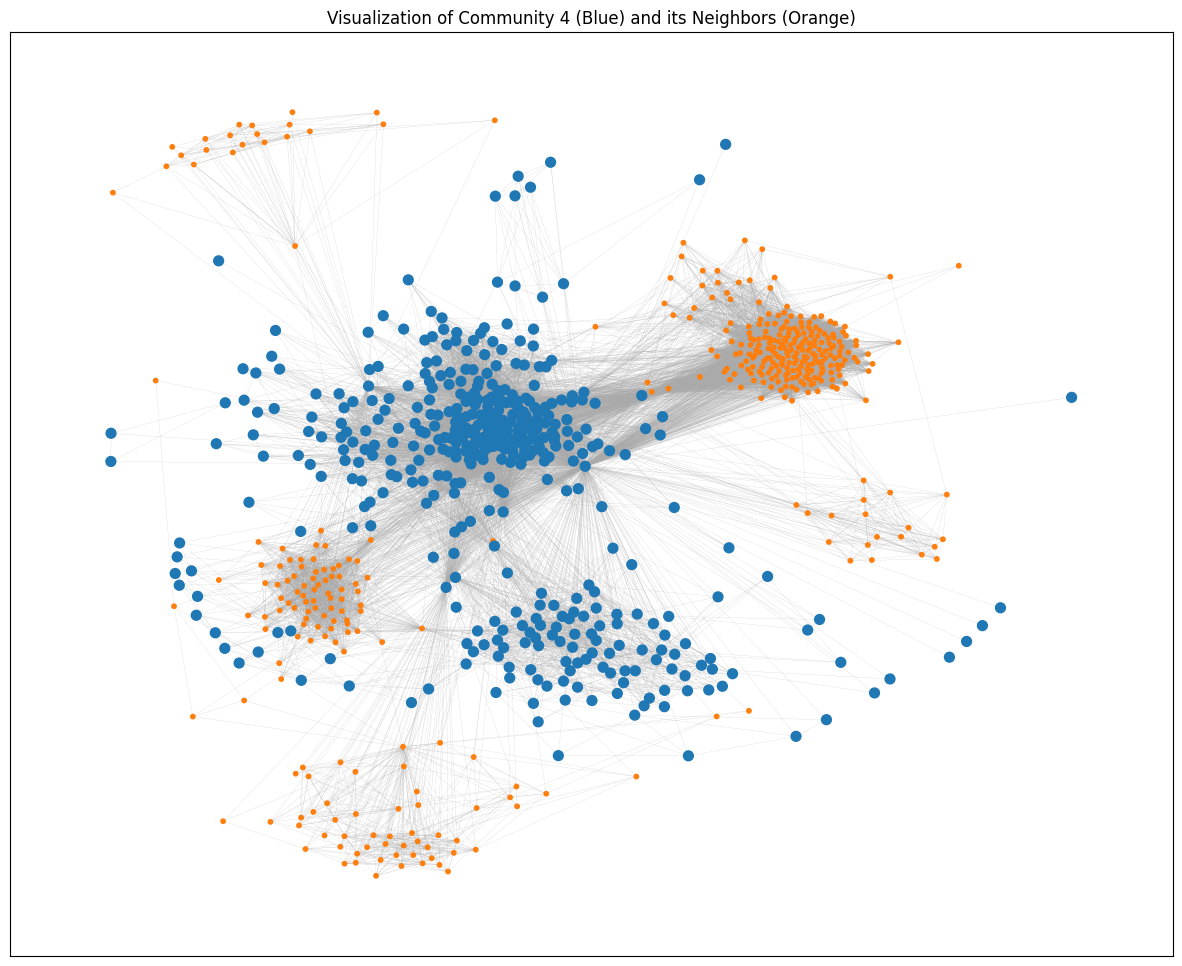

In [70]:
# Visualizing a subset community from Louvain
target_comm_id = community_sizes_louvain.most_common(10)[4][0]
community_nodes = set()
for node, comm_id in partition_louvain.items():
    if comm_id == target_comm_id:
        community_nodes.add(node)

nodes_to_plot = set(community_nodes)
for node in community_nodes:
    for neighbor in G_fb.neighbors(node):
        nodes_to_plot.add(neighbor)
G_sub = G_fb.subgraph(nodes_to_plot)

color_map = []
size_map = []
for node in G_sub.nodes():
    if node in community_nodes:
        color_map.append('#1f77b4') # Blue for core
        size_map.append(50)         # Larger size for core
    else:
        color_map.append('#ff7f0e') # Orange for neighbors
        size_map.append(10)         # Smaller size for neighbors

pos = nx.spring_layout(G_sub, k=0.15, iterations=50, seed=42)

plt.figure(figsize=(15, 12))
nx.draw_networkx(
    G_sub,
    pos,
    node_color=color_map,
    node_size=size_map,
    with_labels=False,
    width=0.1,
    edge_color='#AAAAAA'
)
plt.title(f'Visualization of Community {target_comm_id} (Blue) and its Neighbors (Orange)')

**Key Insights:**

This visualization plots a single sample community (blue) and its immediate neighbors (orange). The blue nodes are, for the most part, densely packed together. This illustrates the high intra-community density that the Louvain algorithm successfully identified. The orange nodes which belong to other communities form their own distinct clusters. The connections between the blue and orange clusters are visibly sparser than the connections within the blue cluster.

Interestingly, there are blue nodes seen further from the community and physically close to the orange clusters. This is probably a consequence of the plotting pulling them towards both orange and blue clusters, but these are basically the neighbor nodes that connect both the clusters and are bridges to the rest of the network.